# Cloud Classification
---
Identify the type of cloud in the sky using deep transfer learning
___

**Author**: Aman Hussain  
**Email**: email at 'first name' + 'last name' dot com  
**Description**: Research notebook for cloud classification 
___

## Import Libraries

In [30]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [31]:
import os
import pandas as pd

In [32]:
from fastai.vision import *
from fastai.metrics import error_rate

## Types of Cloud

**Source**: [UCAR](https://scied.ucar.edu/webweather/clouds/cloud-types)

![Types of Clouds](https://scied.ucar.edu/sites/default/files/images/long-content-page/cloudchart.gif)

-    The highest clouds in the atmosphere are cirrocumulus, cirrus, and cirrostratus. Cumulonimbus clouds can also grow to be very high.
-   Mid-level clouds include altocumulus and altostratus.
-    The lowest clouds in the atmosphere are stratus, cumulus, and stratocumulus.

## Create Dataset

**Package Source**: [fastclass](https://github.com/cwerner/fastclass)  
A little set of tools to batch download images and weed through, delete and classify them into groups for building deep learning image datasets.

**Install fastclass to download images from search engines**

! pip install git+https://github.com/cwerner/fastclass.git#egg=fastclass 

! fcd -c ALL -k -o data image_queries.csv

**Split data into train, validation and test subfolders**

In [6]:
DATA_PATH = Path("../data")

In [5]:
labels = [x.name for x in DATA_PATH.iterdir() if x.is_dir()]

In [7]:
labels

['altostratus',
 'stratocumulus_d',
 'cirrus',
 'cumulus',
 'altocumulus',
 'cirrostratus',
 'cirrocumulus',
 'stratus',
 'cumulonimbus']

Create Imagenet-like directory structure:

In [8]:
os.mkdir(DATA_PATH/'train')
os.mkdir(DATA_PATH/'valid')
os.mkdir(DATA_PATH/'test')

In [9]:
for label in labels:
    os.mkdir(DATA_PATH/'train'/label)
    os.mkdir(DATA_PATH/'valid'/label)
    os.mkdir(DATA_PATH/'test'/label)

Populate the data directory

In [10]:
TEST_SIZE = 100
VALID_SIZE = 100

In [11]:
for label in labels:
    label_path = DATA_PATH/label
    
    label_files = label_path.ls()
    for i in range(TEST_SIZE):
        label_files[i].rename(
            DATA_PATH/'test'/label/label_files[i].name)
    
    label_files = label_path.ls()
    for i in range(VALID_SIZE):
        label_files[i].rename(
            DATA_PATH/'valid'/label/label_files[i].name)
    
    label_files = label_path.ls()
    for label_file in label_files:
        label_file.rename(
            DATA_PATH/'train'/label/label_file.name)

Clean up

In [12]:
for label in labels:
    os.rmdir(DATA_PATH/label)

In [13]:
! rm ../data/*.log

## Load Data

In [4]:
doc(ImageDataBunch.from_folder)

from_folder [source] from_folder ( `path` : PathOrStr , `train` : PathOrStr = `'train'` , `valid` : PathOrStr = `'valid'` , `valid_pct` = `None` , `classes` : Collection [ T_co ]= `None` , `kwargs` : Any ) → ImageDataBunch 
 
 Create from imagenet style dataset in path with train , valid , test subfolders (or provide valid_pct ). 
 Show in docs

In [7]:
data = ImageDataBunch.from_folder(DATA_PATH)

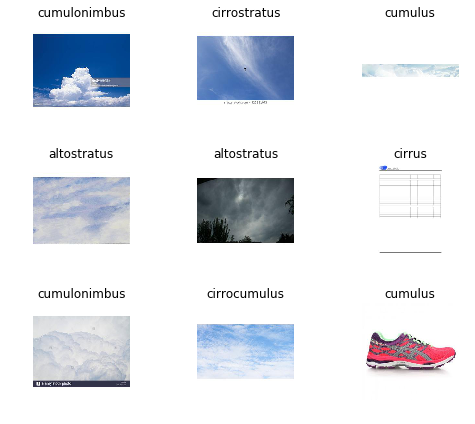

In [8]:
data.show_batch(rows=3, figsize=(7,6))

**NOTES: The dataset has many random images not related to clouds at all.**  

## Exploratory Data Analysis

In [9]:
data.classes

['altocumulus',
 'altostratus',
 'cirrocumulus',
 'cirrostratus',
 'cirrus',
 'cumulonimbus',
 'cumulus',
 'stratocumulus_d',
 'stratus']

In [10]:
data.c

9

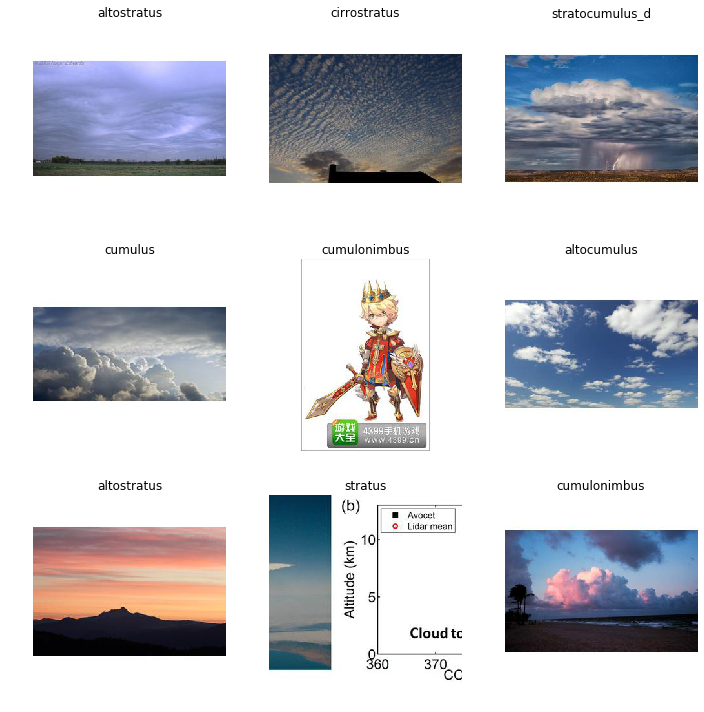

In [11]:
data.show_batch(rows=3, figsize=(10,10))

## Train Model: Resnet34 already trained on Imagenet 

In [12]:
doc(create_cnn)

create_cnn [source] create_cnn ( `data` : DataBunch , `arch` : Callable , `cut` : Union [ int , Callable ]= `None` , `pretrained` : bool = `True` , `lin_ftrs` : Optional [ Collection [ int ]]= `None` , `ps` : Floats = `0.5` , `custom_head` : Optional [ Module ]= `None` , `split_on` : Union [ Callable , Collection [ ModuleList ], NoneType ]= `None` , `bn_final` : bool = `False` , `kwargs` : Any ) → Learner 
 
 Build convnet style learners. 
 Show in docs

In [13]:
learner = create_cnn(data, models.resnet34, metrics=error_rate)

In [14]:
print(learner.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 150, 150]   9408       False     
______________________________________________________________________
BatchNorm2d          [64, 64, 150, 150]   128        True      
______________________________________________________________________
ReLU                 [64, 64, 150, 150]   0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 75, 75]     0          False     
______________________________________________________________________
Conv2d               [64, 64, 75, 75]     36864      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 75, 75]     128        True      
______________________________________________________________________
ReLU                 [64, 64, 75, 75]     0          False     
______________________________________________________________

In [15]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,2.057271,1.843459,0.654444
2,1.786894,1.704156,0.611111
3,1.596046,1.663514,0.594444
4,1.452155,1.655338,0.601111


**NOTES:** The model seems to have overfit because train_loss has gone below validation_loss

## Save Model

In [25]:
learner.save('stage-1')

## Results

In [16]:
doc(ClassificationInterpretation)

class ClassificationInterpretation [source] ClassificationInterpretation ( `data` : DataBunch , `probs` : Tensor , `y_true` : Tensor , `losses` : Tensor ) 
 
 Interpretation methods for classification models. 
 Show in docs

In [17]:
interp = ClassificationInterpretation.from_learner(learner)

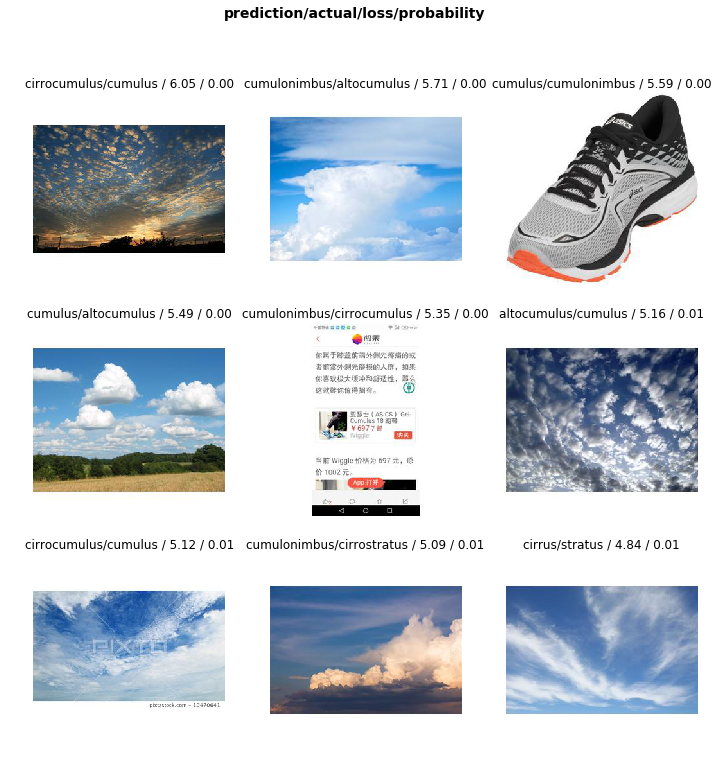

In [21]:
interp.plot_top_losses(9)

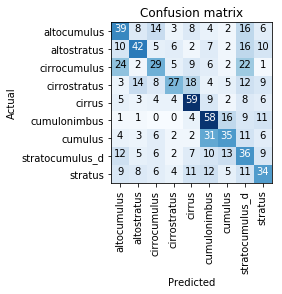

In [22]:
interp.plot_confusion_matrix()

In [24]:
interp.most_confused(min_val=10)

[('cumulus', 'cumulonimbus', 31),
 ('cirrocumulus', 'altocumulus', 24),
 ('cirrocumulus', 'stratocumulus_d', 22),
 ('cirrostratus', 'cirrus', 18),
 ('altocumulus', 'stratocumulus_d', 16),
 ('altostratus', 'stratocumulus_d', 16),
 ('cumulonimbus', 'cumulus', 16),
 ('altocumulus', 'cirrocumulus', 14),
 ('cirrostratus', 'altostratus', 14),
 ('stratocumulus_d', 'cumulus', 13),
 ('cirrostratus', 'stratocumulus_d', 12),
 ('stratocumulus_d', 'altocumulus', 12),
 ('stratus', 'cumulonimbus', 12),
 ('cumulonimbus', 'stratus', 11),
 ('cumulus', 'stratocumulus_d', 11),
 ('stratus', 'cirrus', 11),
 ('stratus', 'stratocumulus_d', 11)]

## Finetune Model

**Train a model from scratch to see the error introduced by transfer learning if any**

In [27]:
learner.unfreeze()

In [ ]:
learner.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate
1,1.710189,1.783073,0.638889


**Finetune model with differential learning rate**

In [35]:
learner.load('stage-1');

In [36]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


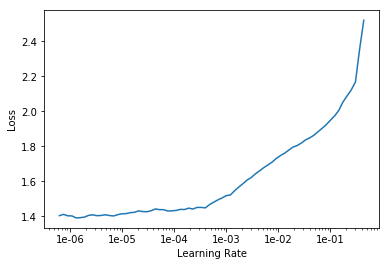

In [37]:
learner.recorder.plot()

**NOTES:** 1e-05 is the best learning rate

In [38]:
learner.unfreeze()

In [39]:
learner.fit_one_cycle(3, max_lr=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate
1,1.415190,1.651497,0.601111
2,1.385831,1.641656,0.595556
3,1.331880,1.637111,0.603333


**NOTES:** Clear overfitting

## Save Model

In [40]:
learner.save('stage-2')

## Results

In [42]:
interp = ClassificationInterpretation.from_learner(learner)

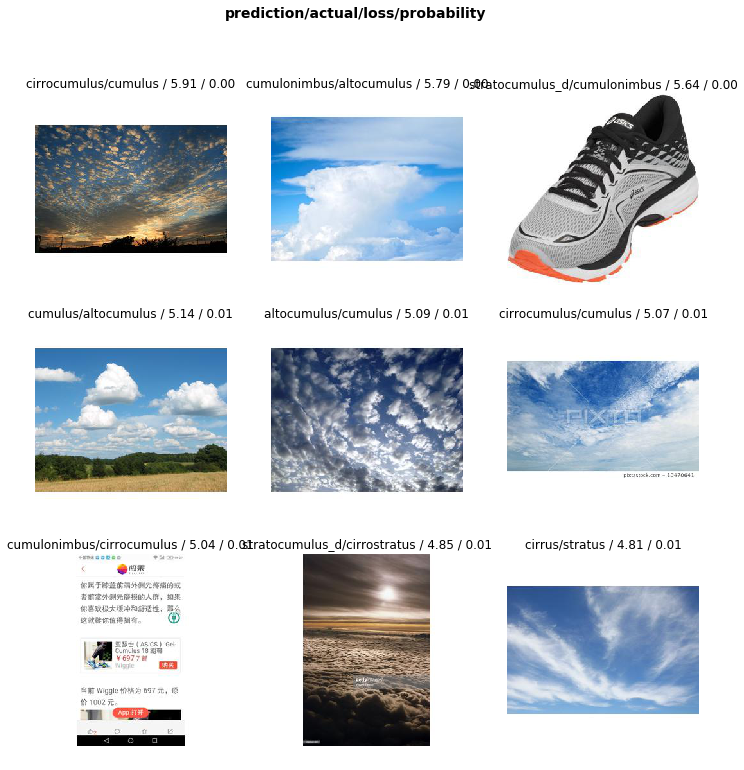

In [44]:
interp.plot_top_losses(9)

**NOTES:**
- All models(untrained, trained on imagenet and finetuned) are overfitting
- Maybe the data needs to cleaned manually.